In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
from glob import glob
import torch
import torch.nn as nn

In [ ]:
class SRDataset(Dataset):
    def __init__(self, hr_dir, upscale_factor=4, patch_size=96):
        super().__init__()
        self.hr_images = sorted(glob(os.path.join(hr_dir, "*")))
        self.upscale = upscale_factor
        self.patch_size = patch_size

        self.hr_transform = transforms.Compose([
            transforms.RandomCrop(patch_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
        self.to_pil = transforms.ToPILImage()

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert("RGB")
        hr = self.hr_transform(hr)

        # Create LR by bicubic downsampling
        c, h, w = hr.shape
        lr_size = (h // self.upscale, w // self.upscale)
        hr_pil = self.to_pil(hr)
        lr_pil = hr_pil.resize((lr_size[1], lr_size[0]), Image.BICUBIC)

        lr = transforms.ToTensor()(lr_pil)
        return lr, hr

In [ ]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, layer_index=36, device="cpu"):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.features = nn.Sequential(*list(vgg)[:layer_index]).to(device)
        for param in self.features.parameters():
            param.requires_grad = False

        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x):
        x = (x - self.mean) / self.std
        return self.features(x)

In [ ]:
# -------- Residual Block --------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # skip connection

In [ ]:
# -------- Generator --------
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=16, upscale_factor=4):
        super(Generator, self).__init__()

        # Initial feature extraction
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.PReLU()

        # Residual blocks
        res_blocks = []
        for _ in range(num_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # After residual blocks
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Upsampling with PixelShuffle
        upsampling = []
        for _ in range(int(upscale_factor/2)):
            upsampling += [
                nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU()
            ]
        self.upsample = nn.Sequential(*upsampling)

        # Final output
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.res_blocks(out1)
        out = self.bn2(self.conv2(out))
        out = out1 + out  # skip connection
        out = self.upsample(out)
        out = self.conv3(out)
        return out

In [ ]:
# -------- Discriminator --------
class Discriminator(nn.Module):
    def __init__(self, input_size=96):
        super(Discriminator, self).__init__()

        def disc_block(in_channels, out_channels, stride=1, use_bn=True):
            layers = [nn.Conv2d(in_channels, out_channels, 3, stride, 1)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            disc_block(3, 64, stride=1, use_bn=False),
            disc_block(64, 64, stride=2),
            disc_block(64, 128, stride=1),
            disc_block(128, 128, stride=2),
            disc_block(128, 256, stride=1),
            disc_block(256, 256, stride=2),
            disc_block(256, 512, stride=1),
            disc_block(512, 512, stride=2),
        )

        # Dense layers
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # global pooling
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        out = self.classifier(out)
        return out


In [ ]:
G = Generator()
D = Discriminator()

lr = torch.randn(1, 3, 24, 24)  # low-res input
sr = G(lr)
print("Generator output:", sr.shape)  # expect (1, 3, 96, 96)
decision = D(sr)
print("Discriminator output:", decision.shape)  # expect (1, 1)

Generator output: torch.Size([1, 3, 96, 96])
Discriminator output: torch.Size([1, 1])


In [ ]:
def pretrain_generator(G, dataloader, epochs=10, lr=1e-4, out_dir="./outputs"):
    device = next(G.parameters()).device
    optimizer = optim.Adam(G.parameters(), lr=lr)
    criterion = nn.MSELoss()

    os.makedirs(out_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        G.train()
        epoch_loss = 0
        for i, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)

            optimizer.zero_grad()
            sr = G(lr)
            loss = criterion(sr, hr)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            if (i + 1) % 10 == 0:
                print(f"[Pretrain] Epoch {epoch}/{epochs} Batch {i+1}/{len(dataloader)} "
                      f"Loss: {loss.item():.4f}")

        # Save sample output
        save_image(sr.clamp(0, 1), f"{out_dir}/pretrain_epoch_{epoch}.png")
        print(f"[Pretrain] Epoch {epoch}: Avg Loss={epoch_loss/len(dataloader):.4f}")

        torch.save(G.state_dict(), f"{out_dir}/G_pretrain_epoch_{epoch}.pth")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import os
import matplotlib.pyplot as plt

def train_srgan(
    hr_dir,
    pretrain_epochs=10,
    gan_epochs=10,
    batch_size=8,
    lr_g=1e-4,
    lr_d=1e-5,
    upscale_factor=4,
    out_dir="./outputs"
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # Initialize models
    G = Generator(num_residual_blocks=16, upscale_factor=upscale_factor).to(device)
    D = Discriminator().to(device)
    vgg = VGGFeatureExtractor(device=device).to(device)

    # Prepare dataset and dataloader
    dataset = SRDataset(hr_dir, upscale_factor=upscale_factor, patch_size=96)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # ===== Stage 1: Pretrain Generator =====
    print("---- Starting Pretraining ----")
    pretrain_generator(G, dataloader, epochs=pretrain_epochs, lr=lr_g, out_dir=out_dir)

    # ===== Stage 2: Adversarial Training =====
    print("---- Starting Adversarial Training ----")
    adversarial_criterion = nn.BCELoss()
    content_criterion = nn.MSELoss()
    pixel_criterion = nn.MSELoss()

    optimizer_G = optim.Adam(G.parameters(), lr=lr_g)
    optimizer_D = optim.Adam(D.parameters(), lr=lr_d)

    os.makedirs(out_dir, exist_ok=True)

    # ---- Track losses ----
    g_losses = []
    d_losses = []

    print("---- Starting SRGAN Training ----")

    for epoch in range(1, gan_epochs + 1):
        G.train()
        D.train()
        g_loss_total, d_loss_total = 0.0, 0.0

        for i, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            valid = torch.ones((lr.size(0), 1), device=device)
            fake = torch.zeros((lr.size(0), 1), device=device)

            # === Train Discriminator ===
            optimizer_D.zero_grad()
            sr = G(lr).detach()
            real_loss = adversarial_criterion(D(hr), valid)
            fake_loss = adversarial_criterion(D(sr), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # === Train Generator ===
            optimizer_G.zero_grad()
            sr = G(lr)
            adv_loss = adversarial_criterion(D(sr), valid)
            content_loss = content_criterion(vgg(sr), vgg(hr))
            pixel_loss = pixel_criterion(sr, hr)
            g_loss = content_loss + 1e-3 * adv_loss + 1e-2 * pixel_loss
            g_loss.backward()
            optimizer_G.step()

            g_loss_total += g_loss.item()
            d_loss_total += d_loss.item()

            # Optional batch-level progress
            if (i + 1) % 10 == 0 or (i + 1) == len(dataloader):
                print(f"[Epoch {epoch}/{gan_epochs}] "
                      f"Batch {i+1}/{len(dataloader)} | "
                      f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

        # === Epoch summary ===
        avg_g_loss = g_loss_total / len(dataloader)
        avg_d_loss = d_loss_total / len(dataloader)
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)

        print(f"Epoch [{epoch}/{gan_epochs}] Summary -> "
              f"Avg D Loss: {avg_d_loss:.4f} | Avg G Loss: {avg_g_loss:.4f}")
        print("-" * 60)

        # === Save checkpoints ===
        torch.save(G.state_dict(), f"{out_dir}/G_srgan_epoch_{epoch}.pth")
        torch.save(D.state_dict(), f"{out_dir}/D_srgan_epoch_{epoch}.pth")

        # === Visualization every 10 epochs or final epoch ===
        if epoch % 10 == 0 or epoch == gan_epochs:
            G.eval()
            with torch.no_grad():
                lr_sample, hr_sample = next(iter(dataloader))
                lr_sample, hr_sample = lr_sample.to(device), hr_sample.to(device)
                sr_sample = G(lr_sample).clamp(0, 1)

            lr_upsampled = torch.nn.functional.interpolate(
                lr_sample, scale_factor=upscale_factor, mode="bicubic", align_corners=False
            )

            grid = make_grid(
                torch.cat((lr_upsampled, sr_sample, hr_sample), dim=0),
                nrow=lr_sample.size(0),
                normalize=True
            )

            save_path = f"{out_dir}/comparison_epoch_{epoch}.png"
            save_image(grid, save_path)
            print(f"[Visualization] Saved comparison grid at: {save_path}")

            plt.figure(figsize=(12, 6))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.title(f"Epoch {epoch}: LR (Upsampled) | SR (Generated) | HR (Ground Truth)")
            plt.axis("off")
            plt.show()

    # === Plot Loss Curves ===
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(g_losses) + 1), g_losses, label="Generator Loss", linewidth=2)
    plt.plot(range(1, len(d_losses) + 1), d_losses, label="Discriminator Loss", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("SRGAN Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{out_dir}/loss_curve.png")
    plt.show()

    print(f"[Visualization] Saved loss curve at: {out_dir}/loss_curve.png")

Using device: cuda
---- Starting Pretraining ----
[Pretrain] Epoch 1/20 Batch 10/50 Loss: 0.0535
[Pretrain] Epoch 1/20 Batch 20/50 Loss: 0.0335
[Pretrain] Epoch 1/20 Batch 30/50 Loss: 0.0207
[Pretrain] Epoch 1/20 Batch 40/50 Loss: 0.0187
[Pretrain] Epoch 1/20 Batch 50/50 Loss: 0.0179
[Pretrain] Epoch 1: Avg Loss=0.0506
[Pretrain] Epoch 2/20 Batch 10/50 Loss: 0.0178
[Pretrain] Epoch 2/20 Batch 20/50 Loss: 0.0180
[Pretrain] Epoch 2/20 Batch 30/50 Loss: 0.0167
[Pretrain] Epoch 2/20 Batch 40/50 Loss: 0.0149
[Pretrain] Epoch 2/20 Batch 50/50 Loss: 0.0124
[Pretrain] Epoch 2: Avg Loss=0.0153
[Pretrain] Epoch 3/20 Batch 10/50 Loss: 0.0109
[Pretrain] Epoch 3/20 Batch 20/50 Loss: 0.0139
[Pretrain] Epoch 3/20 Batch 30/50 Loss: 0.0108
[Pretrain] Epoch 3/20 Batch 40/50 Loss: 0.0147
[Pretrain] Epoch 3/20 Batch 50/50 Loss: 0.0087
[Pretrain] Epoch 3: Avg Loss=0.0118
[Pretrain] Epoch 4/20 Batch 10/50 Loss: 0.0113
[Pretrain] Epoch 4/20 Batch 20/50 Loss: 0.0112
[Pretrain] Epoch 4/20 Batch 30/50 Loss: 0.0

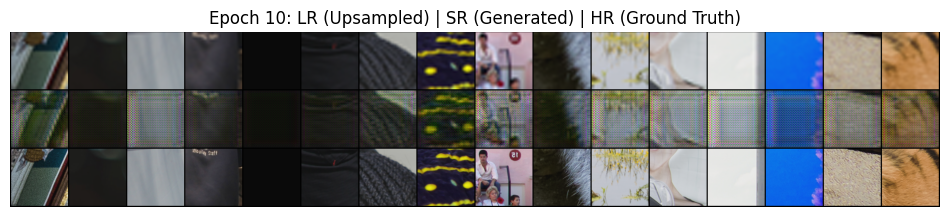

[Epoch 11/100] Batch 10/50 | D Loss: 0.0121 | G Loss: 0.3622
[Epoch 11/100] Batch 20/50 | D Loss: 0.0083 | G Loss: 0.4336
[Epoch 11/100] Batch 30/50 | D Loss: 0.0186 | G Loss: 0.4194
[Epoch 11/100] Batch 40/50 | D Loss: 0.0126 | G Loss: 0.3229
[Epoch 11/100] Batch 50/50 | D Loss: 0.0097 | G Loss: 0.4279
Epoch [11/100] Summary -> Avg D Loss: 0.0277 | Avg G Loss: 0.4050
------------------------------------------------------------
[Epoch 12/100] Batch 10/50 | D Loss: 0.0245 | G Loss: 0.3059
[Epoch 12/100] Batch 20/50 | D Loss: 0.0314 | G Loss: 0.4471
[Epoch 12/100] Batch 30/50 | D Loss: 0.0145 | G Loss: 0.4904
[Epoch 12/100] Batch 40/50 | D Loss: 0.0121 | G Loss: 0.4080
[Epoch 12/100] Batch 50/50 | D Loss: 0.0099 | G Loss: 0.3360
Epoch [12/100] Summary -> Avg D Loss: 0.0242 | Avg G Loss: 0.3846
------------------------------------------------------------
[Epoch 13/100] Batch 10/50 | D Loss: 0.0086 | G Loss: 0.3169
[Epoch 13/100] Batch 20/50 | D Loss: 0.0311 | G Loss: 0.5196
[Epoch 13/100]

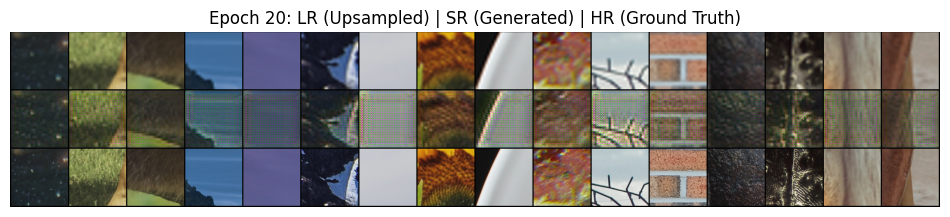

[Epoch 21/100] Batch 10/50 | D Loss: 0.0032 | G Loss: 0.3595
[Epoch 21/100] Batch 20/50 | D Loss: 0.0234 | G Loss: 0.3426
[Epoch 21/100] Batch 30/50 | D Loss: 0.0567 | G Loss: 0.5436
[Epoch 21/100] Batch 40/50 | D Loss: 0.0271 | G Loss: 0.4728
[Epoch 21/100] Batch 50/50 | D Loss: 0.0056 | G Loss: 0.4628
Epoch [21/100] Summary -> Avg D Loss: 0.0116 | Avg G Loss: 0.3921
------------------------------------------------------------
[Epoch 22/100] Batch 10/50 | D Loss: 0.0023 | G Loss: 0.2459
[Epoch 22/100] Batch 20/50 | D Loss: 0.0367 | G Loss: 0.5496
[Epoch 22/100] Batch 30/50 | D Loss: 0.0119 | G Loss: 0.5061
[Epoch 22/100] Batch 40/50 | D Loss: 0.0119 | G Loss: 0.2934
[Epoch 22/100] Batch 50/50 | D Loss: 0.0021 | G Loss: 0.2123
Epoch [22/100] Summary -> Avg D Loss: 0.0089 | Avg G Loss: 0.3635
------------------------------------------------------------
[Epoch 23/100] Batch 10/50 | D Loss: 0.0034 | G Loss: 0.4017
[Epoch 23/100] Batch 20/50 | D Loss: 0.0046 | G Loss: 0.3081
[Epoch 23/100]

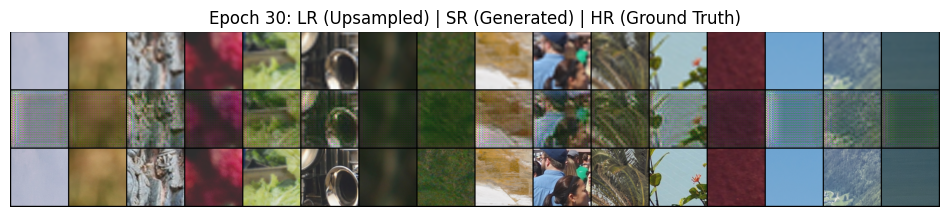

[Epoch 31/100] Batch 10/50 | D Loss: 0.0014 | G Loss: 0.3949
[Epoch 31/100] Batch 20/50 | D Loss: 0.0020 | G Loss: 0.3569
[Epoch 31/100] Batch 30/50 | D Loss: 0.0008 | G Loss: 0.2089
[Epoch 31/100] Batch 40/50 | D Loss: 0.0049 | G Loss: 0.3312
[Epoch 31/100] Batch 50/50 | D Loss: 0.0015 | G Loss: 0.2649
Epoch [31/100] Summary -> Avg D Loss: 0.0050 | Avg G Loss: 0.3774
------------------------------------------------------------
[Epoch 32/100] Batch 10/50 | D Loss: 0.0038 | G Loss: 0.3661
[Epoch 32/100] Batch 20/50 | D Loss: 0.0030 | G Loss: 0.2955
[Epoch 32/100] Batch 30/50 | D Loss: 0.0078 | G Loss: 0.2372
[Epoch 32/100] Batch 40/50 | D Loss: 0.0012 | G Loss: 0.2977
[Epoch 32/100] Batch 50/50 | D Loss: 0.0010 | G Loss: 0.2029
Epoch [32/100] Summary -> Avg D Loss: 0.0042 | Avg G Loss: 0.3523
------------------------------------------------------------
[Epoch 33/100] Batch 10/50 | D Loss: 0.0054 | G Loss: 0.5365
[Epoch 33/100] Batch 20/50 | D Loss: 0.0008 | G Loss: 0.2756
[Epoch 33/100]

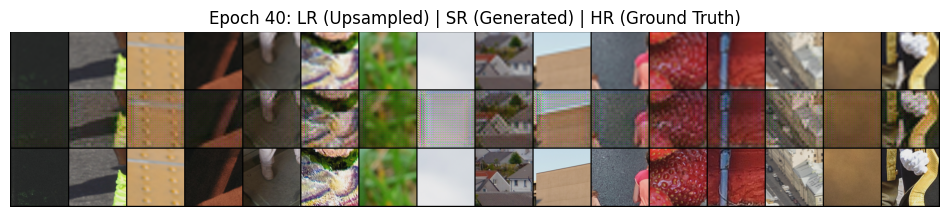

[Epoch 41/100] Batch 10/50 | D Loss: 0.0016 | G Loss: 0.5047
[Epoch 41/100] Batch 20/50 | D Loss: 0.0013 | G Loss: 0.3663
[Epoch 41/100] Batch 30/50 | D Loss: 0.0011 | G Loss: 0.6552
[Epoch 41/100] Batch 40/50 | D Loss: 0.0009 | G Loss: 0.3674
[Epoch 41/100] Batch 50/50 | D Loss: 0.0006 | G Loss: 0.1909
Epoch [41/100] Summary -> Avg D Loss: 0.0028 | Avg G Loss: 0.3501
------------------------------------------------------------
[Epoch 42/100] Batch 10/50 | D Loss: 0.0003 | G Loss: 0.3023
[Epoch 42/100] Batch 20/50 | D Loss: 0.0005 | G Loss: 0.2750
[Epoch 42/100] Batch 30/50 | D Loss: 0.0004 | G Loss: 0.3860
[Epoch 42/100] Batch 40/50 | D Loss: 0.0020 | G Loss: 0.3082
[Epoch 42/100] Batch 50/50 | D Loss: 0.0015 | G Loss: 0.3153
Epoch [42/100] Summary -> Avg D Loss: 0.0029 | Avg G Loss: 0.3541
------------------------------------------------------------
[Epoch 43/100] Batch 10/50 | D Loss: 0.0019 | G Loss: 0.2830
[Epoch 43/100] Batch 20/50 | D Loss: 0.0017 | G Loss: 0.3762
[Epoch 43/100]

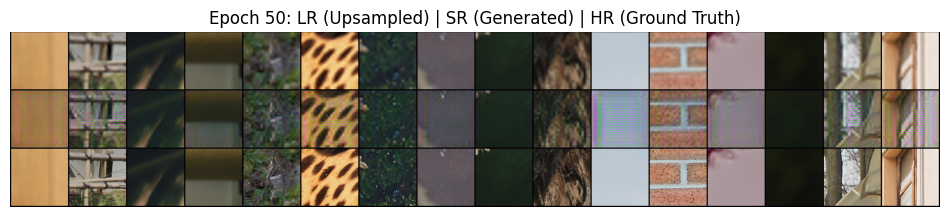

[Epoch 51/100] Batch 10/50 | D Loss: 0.0007 | G Loss: 0.3165
[Epoch 51/100] Batch 20/50 | D Loss: 0.0045 | G Loss: 0.4926
[Epoch 51/100] Batch 30/50 | D Loss: 0.0125 | G Loss: 0.2902
[Epoch 51/100] Batch 40/50 | D Loss: 0.0097 | G Loss: 0.4293
[Epoch 51/100] Batch 50/50 | D Loss: 0.0009 | G Loss: 0.2441
Epoch [51/100] Summary -> Avg D Loss: 0.0016 | Avg G Loss: 0.3319
------------------------------------------------------------
[Epoch 52/100] Batch 10/50 | D Loss: 0.0066 | G Loss: 0.3636
[Epoch 52/100] Batch 20/50 | D Loss: 0.0035 | G Loss: 0.3839
[Epoch 52/100] Batch 30/50 | D Loss: 0.0004 | G Loss: 0.3178
[Epoch 52/100] Batch 40/50 | D Loss: 0.0015 | G Loss: 0.2682
[Epoch 52/100] Batch 50/50 | D Loss: 0.0002 | G Loss: 0.3235
Epoch [52/100] Summary -> Avg D Loss: 0.0010 | Avg G Loss: 0.3240
------------------------------------------------------------
[Epoch 53/100] Batch 10/50 | D Loss: 0.0004 | G Loss: 0.2517
[Epoch 53/100] Batch 20/50 | D Loss: 0.0005 | G Loss: 0.2873
[Epoch 53/100]

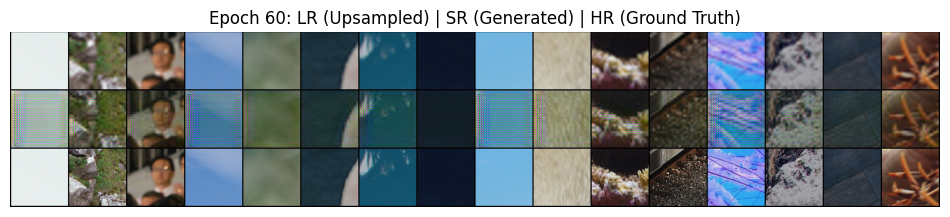

[Epoch 61/100] Batch 10/50 | D Loss: 0.0005 | G Loss: 0.2999
[Epoch 61/100] Batch 20/50 | D Loss: 0.0002 | G Loss: 0.1802
[Epoch 61/100] Batch 30/50 | D Loss: 0.0006 | G Loss: 0.4229
[Epoch 61/100] Batch 40/50 | D Loss: 0.0008 | G Loss: 0.2192
[Epoch 61/100] Batch 50/50 | D Loss: 0.0008 | G Loss: 0.4483
Epoch [61/100] Summary -> Avg D Loss: 0.0006 | Avg G Loss: 0.3318
------------------------------------------------------------
[Epoch 62/100] Batch 10/50 | D Loss: 0.0005 | G Loss: 0.3538
[Epoch 62/100] Batch 20/50 | D Loss: 0.0022 | G Loss: 0.3603
[Epoch 62/100] Batch 30/50 | D Loss: 0.0031 | G Loss: 0.3944
[Epoch 62/100] Batch 40/50 | D Loss: 0.0010 | G Loss: 0.2875
[Epoch 62/100] Batch 50/50 | D Loss: 0.0001 | G Loss: 0.2678
Epoch [62/100] Summary -> Avg D Loss: 0.0011 | Avg G Loss: 0.3209
------------------------------------------------------------
[Epoch 63/100] Batch 10/50 | D Loss: 0.0036 | G Loss: 0.2740
[Epoch 63/100] Batch 20/50 | D Loss: 0.0006 | G Loss: 0.2768
[Epoch 63/100]

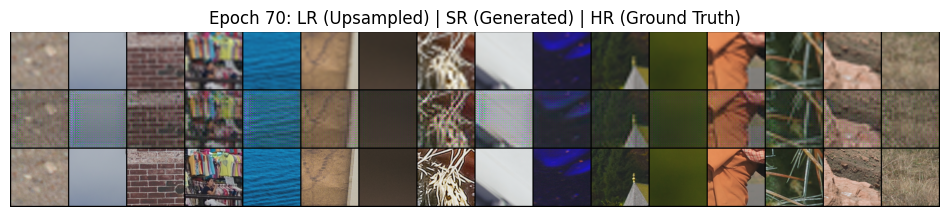

[Epoch 71/100] Batch 10/50 | D Loss: 0.0001 | G Loss: 0.2395
[Epoch 71/100] Batch 20/50 | D Loss: 0.0039 | G Loss: 0.3570
[Epoch 71/100] Batch 30/50 | D Loss: 0.0002 | G Loss: 0.3290
[Epoch 71/100] Batch 40/50 | D Loss: 0.0013 | G Loss: 0.2436
[Epoch 71/100] Batch 50/50 | D Loss: 0.0001 | G Loss: 0.2000
Epoch [71/100] Summary -> Avg D Loss: 0.0005 | Avg G Loss: 0.3169
------------------------------------------------------------
[Epoch 72/100] Batch 10/50 | D Loss: 0.0014 | G Loss: 0.4014
[Epoch 72/100] Batch 20/50 | D Loss: 0.0002 | G Loss: 0.3291
[Epoch 72/100] Batch 30/50 | D Loss: 0.0003 | G Loss: 0.3292
[Epoch 72/100] Batch 40/50 | D Loss: 0.0001 | G Loss: 0.3363
[Epoch 72/100] Batch 50/50 | D Loss: 0.0001 | G Loss: 0.4325
Epoch [72/100] Summary -> Avg D Loss: 0.0004 | Avg G Loss: 0.3338
------------------------------------------------------------
[Epoch 73/100] Batch 10/50 | D Loss: 0.0007 | G Loss: 0.4099
[Epoch 73/100] Batch 20/50 | D Loss: 0.0001 | G Loss: 0.4413
[Epoch 73/100]

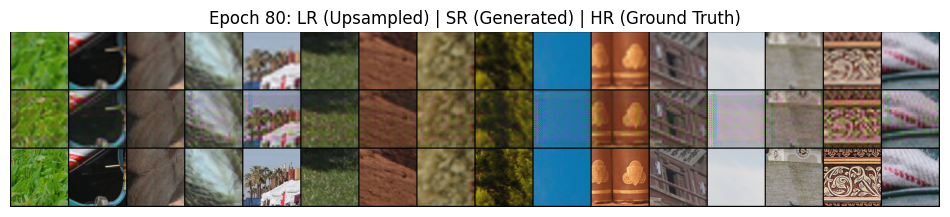

[Epoch 81/100] Batch 10/50 | D Loss: 0.0048 | G Loss: 0.3666
[Epoch 81/100] Batch 20/50 | D Loss: 0.0553 | G Loss: 0.2487
[Epoch 81/100] Batch 30/50 | D Loss: 0.0165 | G Loss: 0.3241
[Epoch 81/100] Batch 40/50 | D Loss: 0.0040 | G Loss: 0.2652
[Epoch 81/100] Batch 50/50 | D Loss: 0.0079 | G Loss: 0.2764
Epoch [81/100] Summary -> Avg D Loss: 0.0132 | Avg G Loss: 0.3043
------------------------------------------------------------
[Epoch 82/100] Batch 10/50 | D Loss: 0.0016 | G Loss: 0.2454
[Epoch 82/100] Batch 20/50 | D Loss: 0.0760 | G Loss: 0.3149
[Epoch 82/100] Batch 30/50 | D Loss: 0.0045 | G Loss: 0.3615
[Epoch 82/100] Batch 40/50 | D Loss: 0.3284 | G Loss: 0.2399
[Epoch 82/100] Batch 50/50 | D Loss: 0.0376 | G Loss: 0.2931
Epoch [82/100] Summary -> Avg D Loss: 0.0379 | Avg G Loss: 0.3270
------------------------------------------------------------
[Epoch 83/100] Batch 10/50 | D Loss: 0.0389 | G Loss: 0.3878
[Epoch 83/100] Batch 20/50 | D Loss: 0.0157 | G Loss: 0.1916
[Epoch 83/100]

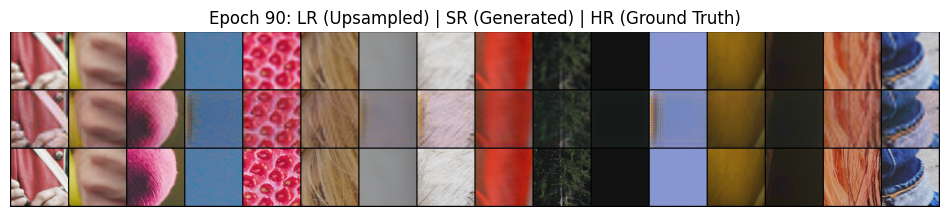

[Epoch 91/100] Batch 10/50 | D Loss: 0.1879 | G Loss: 0.2843
[Epoch 91/100] Batch 20/50 | D Loss: 0.0250 | G Loss: 0.2533
[Epoch 91/100] Batch 30/50 | D Loss: 0.0156 | G Loss: 0.2380
[Epoch 91/100] Batch 40/50 | D Loss: 0.0072 | G Loss: 0.3016
[Epoch 91/100] Batch 50/50 | D Loss: 0.0032 | G Loss: 0.2343
Epoch [91/100] Summary -> Avg D Loss: 0.0538 | Avg G Loss: 0.3033
------------------------------------------------------------
[Epoch 92/100] Batch 10/50 | D Loss: 0.0633 | G Loss: 0.5079
[Epoch 92/100] Batch 20/50 | D Loss: 0.0122 | G Loss: 0.4896
[Epoch 92/100] Batch 30/50 | D Loss: 0.0161 | G Loss: 0.3579
[Epoch 92/100] Batch 40/50 | D Loss: 0.0053 | G Loss: 0.1201
[Epoch 92/100] Batch 50/50 | D Loss: 0.1056 | G Loss: 0.2830
Epoch [92/100] Summary -> Avg D Loss: 0.0223 | Avg G Loss: 0.3356
------------------------------------------------------------
[Epoch 93/100] Batch 10/50 | D Loss: 0.0298 | G Loss: 0.4135
[Epoch 93/100] Batch 20/50 | D Loss: 0.0505 | G Loss: 0.2905
[Epoch 93/100]

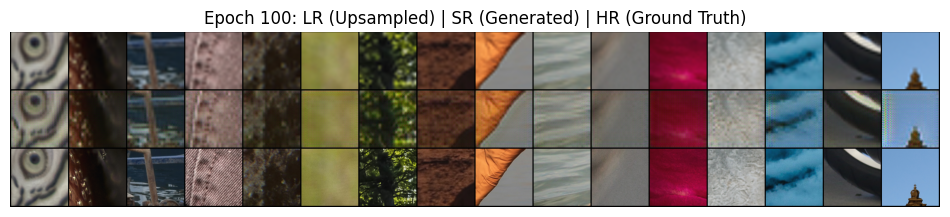

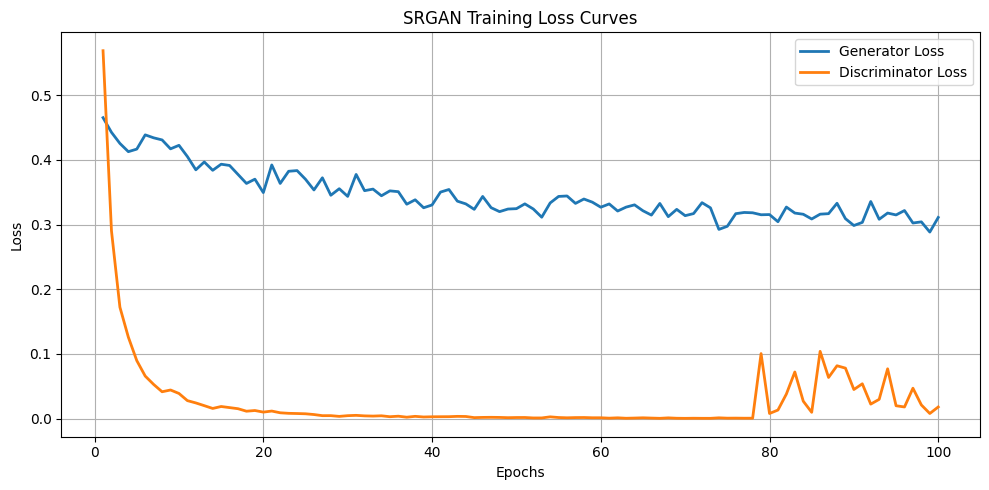

[Visualization] Saved loss curve at: ./outputs/loss_curve.png


In [ ]:
train_srgan(
    hr_dir="/content/drive/MyDrive/SRGAN/Div2K High Resolution Images/DIV2K_train_HR/DIV2K_train_HR",
    pretrain_epochs=20,  # pixel-only training
    gan_epochs=100,       # adversarial training
    batch_size=16
)

In [ ]:
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os

# -------- Evaluation --------
def evaluate(generator_path, hr_dir, upscale_factor=4, num_samples=5, out_dir="./outputs"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    G = Generator(upscale_factor=upscale_factor).to(device)
    G.load_state_dict(torch.load(generator_path, map_location=device))
    G.eval()

    dataset = SRDataset(hr_dir, upscale_factor=upscale_factor, patch_size=96)
    os.makedirs(out_dir, exist_ok=True)

    with torch.no_grad():
        for i in range(num_samples):
            lr, hr = dataset[i]
            lr, hr = lr.unsqueeze(0).to(device), hr.unsqueeze(0).to(device)

            sr = G(lr)

            # Clamp values [0,1]
            lr = lr.clamp(0, 1)
            sr = sr.clamp(0, 1)
            hr = hr.clamp(0, 1)

            # Upsample LR to match HR size (for visualization only)
            lr_up = nn.functional.interpolate(lr, size=hr.shape[-2:], mode="bicubic")

            # Make comparison grid: LR | SR | HR
            grid = make_grid(torch.cat([lr_up, sr, hr], dim=0), nrow=3)
            save_image(grid, f"{out_dir}/eval_{i+1}.png")
            print(f"Saved comparison to {out_dir}/eval_{i+1}.png")

            # --- Display using Matplotlib ---
            plt.figure(figsize=(12, 4))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert to HWC format for Matplotlib
            plt.title(f"Sample {i+1} — LR | SR | HR")
            plt.axis("off")
            plt.show()

Saved comparison to ./outputs/eval_1.png


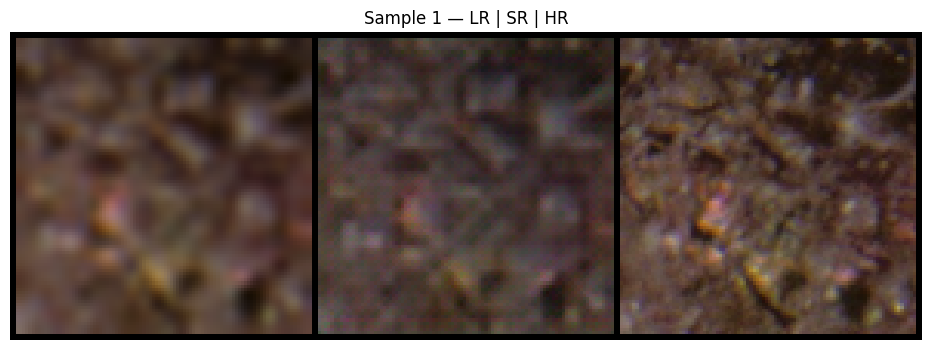

Saved comparison to ./outputs/eval_2.png


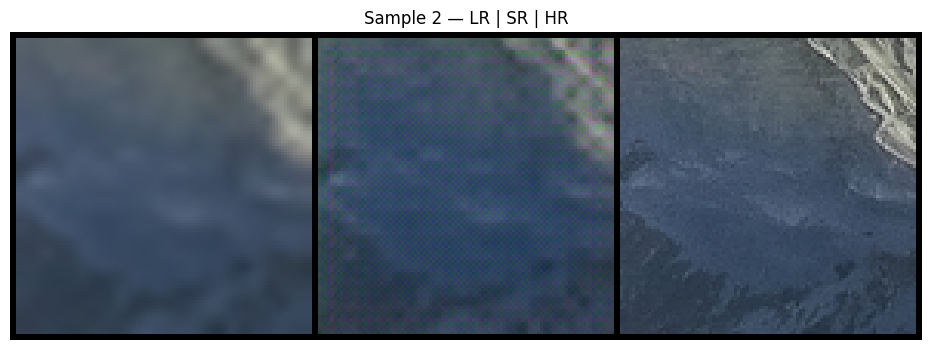

Saved comparison to ./outputs/eval_3.png


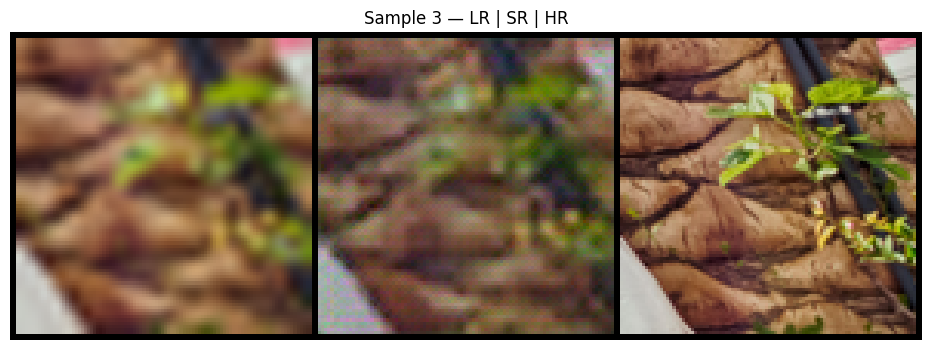

Saved comparison to ./outputs/eval_4.png


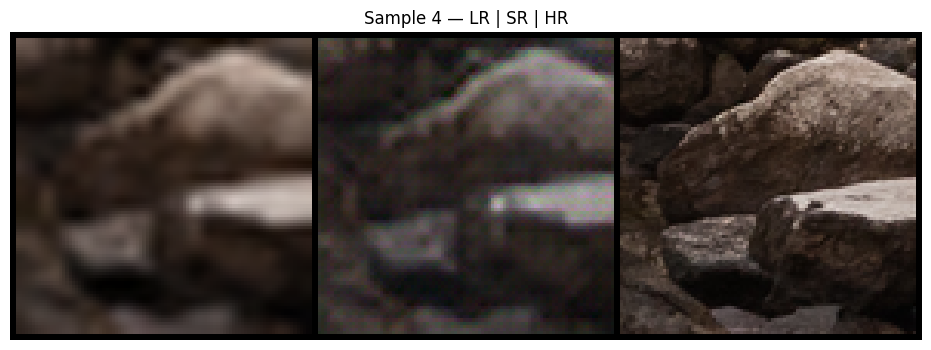

Saved comparison to ./outputs/eval_5.png


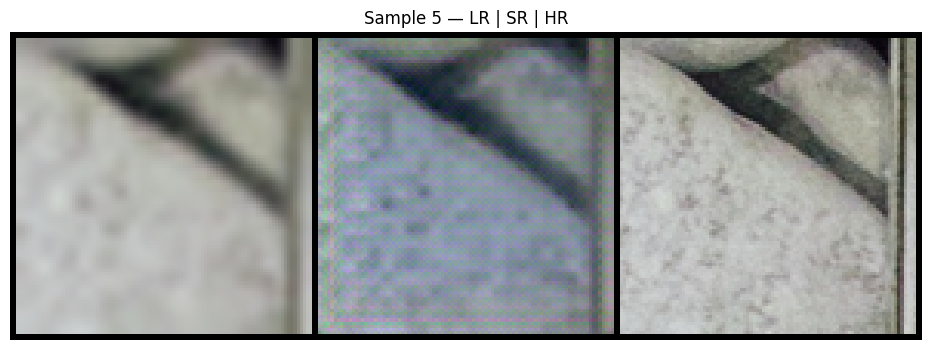

In [ ]:
evaluate(
    generator_path="/content/drive/MyDrive/Models/generator_srgan.pth",  # pick best checkpoint
    hr_dir="/content/drive/MyDrive/SRGAN/Div2K High Resolution Images/DIV2K_train_HR/DIV2K_train_HR",
    num_samples=5
)

In [ ]:
import torch

# Recreate model architecture
device = "cuda" if torch.cuda.is_available() else "cpu"
G = Generator(upscale_factor=4).to(device)

# Load the last (or best) checkpoint from your outputs folder
G.load_state_dict(torch.load("./outputs/G_srgan_epoch_200.pth", map_location=device))

# Save a clean, final version
print("✅ Model saved as generator_srgan_final.pth")

torch.save(G.state_dict(), "/content/drive/MyDrive/Models/generator_srgan.pth")

In [ ]:
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os

# -------- Evaluation --------
def evaluate(generator_path, hr_dir, upscale_factor=4, num_samples=5, out_dir="./outputs"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    G = Generator(upscale_factor=upscale_factor).to(device)
    G.load_state_dict(torch.load(generator_path, map_location=device))
    G.eval()

    dataset = SRDataset(hr_dir, upscale_factor=upscale_factor, patch_size=96)
    os.makedirs(out_dir, exist_ok=True)

    with torch.no_grad():
        for i in range(num_samples):
            lr, hr = dataset[i]
            lr, hr = lr.unsqueeze(0).to(device), hr.unsqueeze(0).to(device)

            sr = G(lr)

            # Clamp values [0,1]
            lr = lr.clamp(0, 1)
            sr = sr.clamp(0, 1)
            hr = hr.clamp(0, 1)

            # Upsample LR to match HR size (for visualization only)
            lr_up = nn.functional.interpolate(lr, size=hr.shape[-2:], mode="bicubic")

            # Make comparison grid: LR | SR | HR
            grid = make_grid(torch.cat([lr_up, sr, hr], dim=0), nrow=3)
            save_image(grid, f"{out_dir}/eval_{i+1}.png")
            print(f"Saved comparison to {out_dir}/eval_{i+1}.png")

            # --- Display using Matplotlib ---
            plt.figure(figsize=(12, 4))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert to HWC format for Matplotlib
            plt.title(f"Sample {i+1} — LR | SR | HR")
            plt.axis("off")
            plt.show()

In [ ]:
evaluate(
    generator_path="/content/drive/MyDrive/Models/generator_srgan.pth",  # pick best checkpoint
    hr_dir="/content/drive/MyDrive/SRGAN/Div2K High Resolution Images/DIV2K_train_HR/DIV2K_train_HR",
    num_samples=5
)